In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

data  = pd.read_csv('scraped_data/cancerUK.csv')

data.head()

,user,thread,time,text
0,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 09:41,Hi y'all.As I posted before I'm in this forum ...
1,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 09:53 in response to lonelygirl,"Hi Lonelygirl, I'm soo sorry for what you are ..."
2,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:02 in response to lonelygirl,Hello again; I remembered the discussions we h...
3,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:43 in response to RosieApples,Hi @RosieApples ‍Thank you for replying. I don...
4,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:57 in response to Annieliz,Hi @Annieliz ‍ I'm happy that you reply to me ...


In [2]:
combi = data

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

# remove twitter handles (@user)
combi['tidy_text'] = np.vectorize(remove_pattern)(combi['text'], "@[\w]*")

# remove special characters, numbers, punctuations
combi['tidy_text'] = combi['tidy_text'].str.replace("[^a-zA-Z#]", " ")

combi['tidy_text'] = combi['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi.head()

,user,thread,time,text,tidy_text
0,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 09:41,Hi y'all.As I posted before I'm in this forum ...,posted before this forum because boyfriend sta...
1,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 09:53 in response to lonelygirl,"Hi Lonelygirl, I'm soo sorry for what you are ...",Lonelygirl sorry what going through this just ...
2,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:02 in response to lonelygirl,Hello again; I remembered the discussions we h...,Hello again remembered discussions months that...
3,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:43 in response to RosieApples,Hi @RosieApples ‍Thank you for replying. I don...,Thank replying think there support groups here...
4,lonelygirl,Boyfriend with stage 4 colon cancer with liver...,6 Feb 2019 10:57 in response to Annieliz,Hi @Annieliz ‍ I'm happy that you reply to me ...,happy that reply once again remember That make...


In [3]:
tokenized_tweet = combi['tidy_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [posted, before, this, forum, because, boyfrie...
1    [Lonelygirl, sorry, what, going, through, this...
2    [Hello, again, remembered, discussions, months...
3    [Thank, replying, think, there, support, group...
4    [happy, that, reply, once, again, remember, Th...
Name: tidy_text, dtype: object

In [4]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [post, befor, thi, forum, becaus, boyfriend, s...
1    [lonelygirl, sorri, what, go, through, thi, ju...
2    [hello, again, rememb, discuss, month, that, t...
3    [thank, repli, think, there, support, group, h...
4    [happi, that, repli, onc, again, rememb, that,...
Name: tidy_text, dtype: object

In [5]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_text'] = tokenized_tweet

In [6]:
all_words = ' '.join([text for text in combi['tidy_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

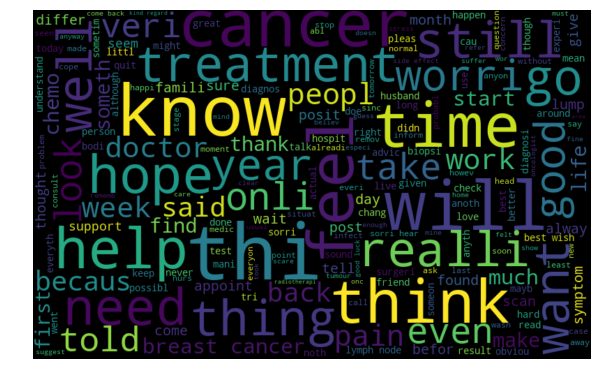

In [7]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [8]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [9]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(combi['tidy_text'])

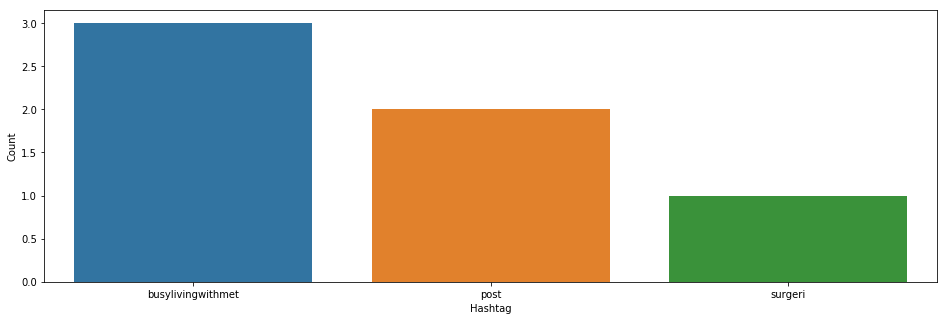

In [10]:
# unnesting list
HT_regular = sum(HT_regular,[])
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_text'])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_text'])

In [13]:
import pickle
pkl_filename = "scraped_data/pickle_model.pkl"  
# Load from file
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)

In [14]:
# Calculate the predict target values
print(pickle_model)
prediction = pickle_model.predict_proba(tfidf)
print(prediction)
Ypredict = pickle_model.predict(bow) 
print(bow)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
[[0.9758981  0.0241019 ]
 [0.96968776 0.03031224]
 [0.98707135 0.01292865]
 ...
 [0.96280026 0.03719974]
 [0.98787043 0.01212957]
 [0.89595148 0.10404852]]
  (0, 341)	2
  (0, 890)	1
  (0, 902)	1
  (0, 373)	1
  (0, 386)	1
  (0, 194)	1
  (0, 43)	1
  (0, 410)	1
  (0, 305)	1
  (0, 336)	1
  (0, 798)	1
  (0, 981)	1
  (0, 452)	1
  (0, 897)	1
  (0, 821)	1
  (0, 74)	2
  (0, 352)	1
  (0, 379)	1
  (0, 116)	1
  (0, 389)	1
  (0, 461)	3
  (0, 997)	1
  (0, 335)	1
  (0, 94)	1
  (0, 549)	2
  :	:
  (4208, 784)	1
  (4208, 165)	1
  (4208, 830)	1
  (4208, 729)	1
  (4208, 570)	1
  (4208, 283)	1
  (4208, 600)	1
  (4208, 270)	1
  (4208, 968)	1
  (4208, 926)	1
  (4209, 619)	1
  (4209, 231)	1
  (4209, 458)	1
  (4209, 401)	1
  (4209, 336)	1
  (4209, 128